In [1]:
import numpy as np
import pandas as pd

### to split the full df into counties

In [ ]:
# full df
full_df = pd.read_csv('/Users/kristof/data/salmon/combined_df.csv')

In [274]:
full_df = full_df[~((full_df['Year'] == 2024) & (full_df['Week'] > 8))]
df = pd.DataFrame(full_df)
# Group by 'County' and create a dictionary of DataFrames
county_dfs = {county: group.reset_index(drop=True) for county, group in df.groupby('County')}

In [275]:

# Iterate over each county DataFrame
for county, county_df in county_dfs.items():
    print(f"Processing data for: {county}")
    
    # Create 'Date' column from 'Year' and 'Week'
    county_df['Date'] = pd.to_datetime(county_df['Year'].astype(str) + county_df['Week'].astype(str) + '1', format='%Y%W%w')
    
    # Set the 'Date' column as index
    county_df.set_index('Date', inplace=True)


    # Update the county_dfs with the processed DataFrame
    county_dfs[county] = county_df

Processing data for: Møre og Romsdal
Processing data for: Nordland
Processing data for: Rogaland
Processing data for: Troms og Finnmark
Processing data for: Trøndelag
Processing data for: Vestland


In [276]:
import os

# Create a directory to save 
os.makedirs('county_csvs', exist_ok=True)

# Iterate over the dictionary and save 
for county, df in county_dfs.items():
    # Define the file name,
    filename = f"county_csvs/{county.replace(' ', '_')}.csv"
    
    # Save the DataFrame to a CSV file
    df.to_csv(filename)
    
    print(f"Saved {county} data to {filename}")

Saved Møre og Romsdal data to county_csvs/Møre_og_Romsdal.csv
Saved Nordland data to county_csvs/Nordland.csv
Saved Rogaland data to county_csvs/Rogaland.csv
Saved Troms og Finnmark data to county_csvs/Troms_og_Finnmark.csv
Saved Trøndelag data to county_csvs/Trøndelag.csv
Saved Vestland data to county_csvs/Vestland.csv


### load individual counties

In [277]:
# can change to look at a different county
df = pd.read_csv('/Users/kristof/data/salmon/county_csvs/Trøndelag.csv')

In [278]:
df

,Date,Week,Year,Disease,County,Latitude,Longitude,Active_Outbreaks,Sites,Norm_Outbreak,Sea temperature,Total lice counts
0,2012-11-05,45,2012,PD,Trøndelag,63.872032,9.769783,222,33.0,6.727273,8.330923,2.388000
1,2012-11-12,46,2012,PD,Trøndelag,63.872032,9.769783,222,33.0,6.727273,8.122500,1.663929
2,2012-11-19,47,2012,PD,Trøndelag,63.872032,9.769783,222,33.0,6.727273,7.951636,1.961455
3,2012-11-26,48,2012,PD,Trøndelag,63.872032,9.769783,222,33.0,6.727273,7.420727,1.727091
4,2012-12-03,49,2012,PD,Trøndelag,63.872032,9.769783,222,33.0,6.727273,6.309302,1.082558
...,...,...,...,...,...,...,...,...,...,...,...,...
19254,2024-02-19,8,2024,PD,Trøndelag,63.617184,9.131100,1091,36.0,30.305556,6.165926,0.497778
19255,2024-02-19,8,2024,PD,Trøndelag,63.655785,9.155250,1091,36.0,30.305556,6.165926,0.497778
19256,2024-02-19,8,2024,PD,Trøndelag,63.980667,9.868733,714,36.0,19.833333,6.165926,0.497778
19257,2024-02-19,8,2024,PD,Trøndelag,63.598217,9.116583,1167,36.0,32.416667,6.165926,0.497778


In [279]:
# dropp some columns , if there are multiple outbreaks per week aggreagte by mean so there is one entry per week 

df_week = df.groupby(['Year', 'Week']).agg({
    'Norm_Outbreak': 'mean',
    'Sea temperature': 'mean',
    'Total lice counts': 'mean'
}).reset_index()

# Optional: Sort by Year and Week
df_week = df_week.sort_values(by=['Year', 'Week'])

In [280]:
df_week

,Year,Week,Norm_Outbreak,Sea temperature,Total lice counts
0,2012,45,6.727273,8.330923,2.388000
1,2012,46,6.727273,8.122500,1.663929
2,2012,47,6.727273,7.951636,1.961455
3,2012,48,6.727273,7.420727,1.727091
4,2012,49,6.727273,6.309302,1.082558
...,...,...,...,...,...
585,2024,4,26.724359,5.459625,0.901750
586,2024,5,26.724359,5.703590,0.788205
587,2024,6,26.724359,5.425926,0.735556
588,2024,7,26.724359,5.218025,0.506420


In [281]:
# need datetime index for timeseries, cobine week year
df_week['Date'] = pd.to_datetime(df_week['Year'].astype(str) + df_week['Week'].astype(str) + '1', format='%G%V%u')

# Set the new date as index and sort
df_week = df_week.set_index('Date')
df_week = df_week.sort_index()

# df = df.drop(columns=['Year', 'Week'])

# prepare for sarimax for SARIMAX
y = df_week['Norm_Outbreak']
X = df_week[['Sea temperature', 'Total lice counts']]

### Decomposation, Trend

<Figure size 23000x1500 with 0 Axes>

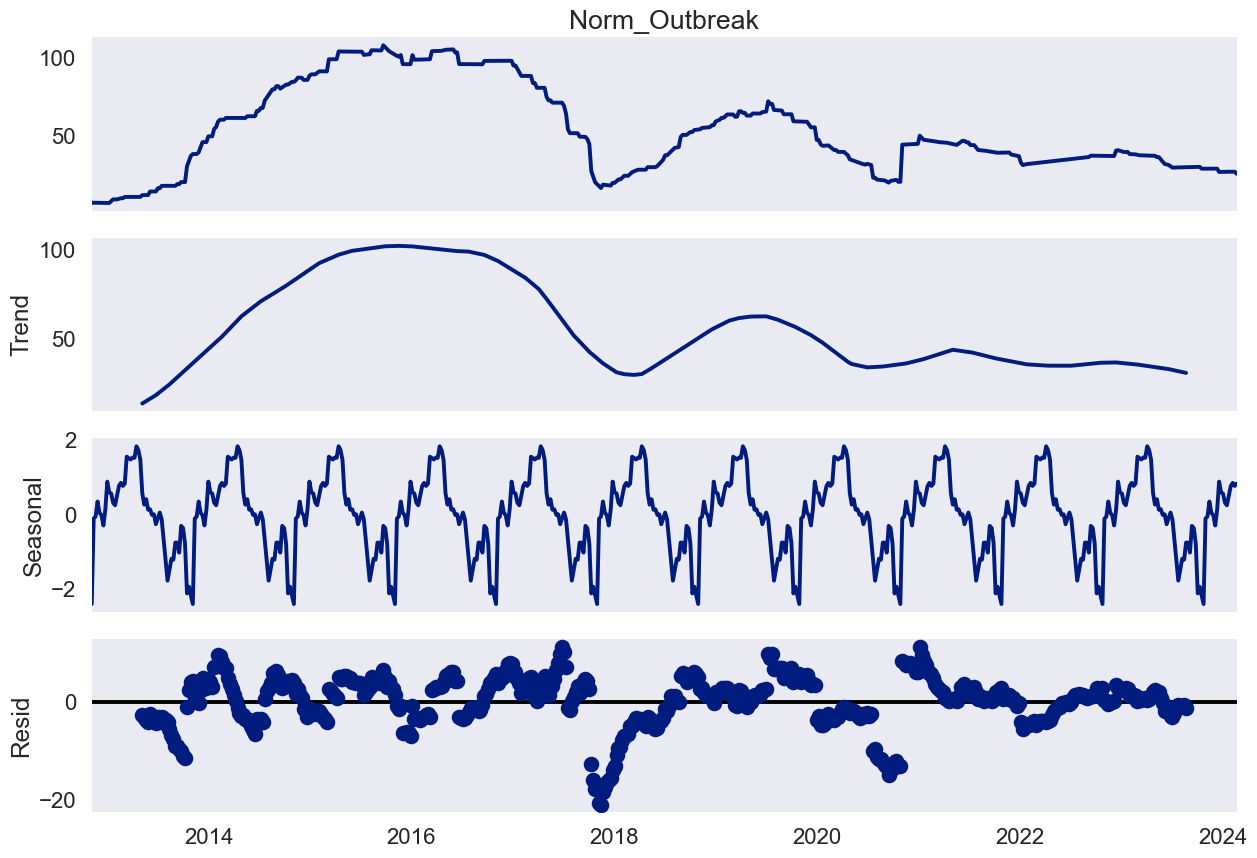

In [282]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose the time series
decomposition = seasonal_decompose(df_week['Norm_Outbreak'], model='additive', period=52)

# Plot the decomposition
plt.style.use('seaborn-v0_8-dark') 
plt.figure(figsize=(230, 15))
decomposition.plot(30,15)
plt.show()

### PCA

In [283]:
# check correlation of exogenous variables

X.corr()

,Sea temperature,Total lice counts
Sea temperature,1.000000,0.535497
Total lice counts,0.535497,1.000000


In [284]:
# Step 1: Normalize
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

# Step 2: PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# put back into DataFrame
X_pca_df = pd.DataFrame(X_pca, index=X.index, columns=['PC1', 'PC2'])

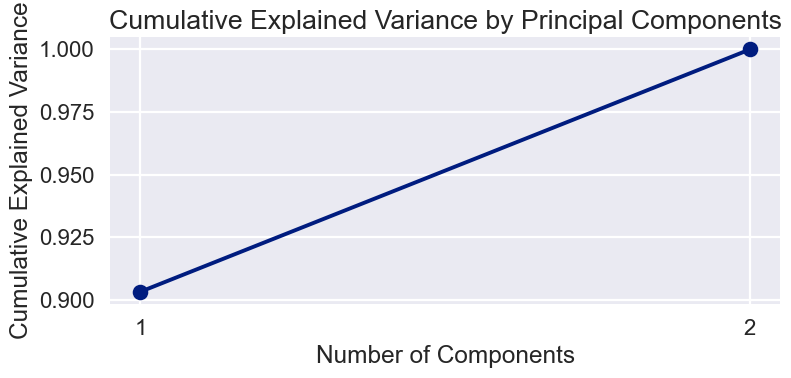

In [287]:
# Plot cumulative explained variance
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(
    np.arange(1, len(pca.explained_variance_ratio_) + 1),  # x = 1, 2, ...
    np.cumsum(pca.explained_variance_ratio_), 
    marker='o'
)

plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1))  # ensure ticks start at 1
plt.grid(True)
plt.tight_layout()
plt.show()

## SARIMAX, SARIMA, ARIMA, PCA SARIMAX

In [288]:
# PCA data train test split
y_train = y[:train_end_date]
y_test = y[train_end_date:]

X_train_pca = X_pca_df[:train_end_date]
X_test_pca = X_pca_df[train_end_date:]

In [289]:
# Full data train test split

train_end_date = '2022-01-01'  

y_train = y[:train_end_date]
X_train = X[:train_end_date]

y_test = y[train_end_date:] 
X_test = X[train_end_date:]  

### hyper parameter tuning ,  tuning opimal p,d,q,  P,D,Q 

In [110]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

# Define parameter ranges
p = d = q = range(0, 3)  # try 0,1,2
P = D = Q = range(0, 2)  # smaller seasonal params
s = 52  # seasonality (weekly data, annual pattern)

# Generate  (p,d,q) x (P,D,Q,s) combinations
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

best_aic = np.inf
best_params = None
best_model = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(
                y,
                exog=X,
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            if model.aic < best_aic:
                best_aic = model.aic
                best_params = (param, seasonal_param)
                best_model = model

        except:
            continue  

print(f"Best SARIMAX order: {best_params[0]} Seasonal order: {best_params[1]} AIC: {best_aic:.2f}")

Best SARIMAX order: (0, 2, 2) Seasonal order: (0, 1, 1, 52) AIC: 2750.38


### fit SARIMAX, ARIMA, SARIMA, PCA SARIMAX

In [321]:
# ordr and seasonal order,  (p,d,q) (P,D,Q,s)

# (0,2,2)
 #(0,1,1,52),

order = 0,2,2
seasonal_order = 0,1,1,52

In [322]:
# define and fit SARIMAX

model = SARIMAX(
    y_train,
    exog=X_train,
    order=(order), 
    seasonal_order=(seasonal_order),  
    enforce_stationarity=False,
    enforce_invertibility=False
)
result = model.fit(disp=False)

# forcast futre
n_test_steps = len(y_test) 
forecast_result = result.get_forecast(steps=n_test_steps, exog=X_test)

# predicted means ad cis
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()


In [323]:
# define and fit ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

arima_model = ARIMA(
    y_train,  # target only
    order=(order)  #  (p,d,q) 
)
arima_result = arima_model.fit()

# Forecast future 
n_steps = len(y_test)
forecast_arima = arima_result.get_forecast(steps=n_steps)

# Get predicted mean and CIs
forecast_mean_arima = forecast_arima.predicted_mean
conf_int_arima = forecast_arima.conf_int()

In [324]:
## define and fit sarimax on PCA data

from statsmodels.tsa.statespace.sarimax import SARIMAX

model_pca = SARIMAX(
    y_train,
    exog=X_train_pca,
    order=(order),
    seasonal_order=(seasonal_order),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result_pca = model_pca.fit(disp=False)

forecast_pca = result_pca.get_forecast(steps=len(y_test), exog=X_test_pca)
forecast_mean_pca = forecast_pca.predicted_mean

In [325]:
# Fit SARIMA with no exogenous variables to check effeect on 

from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(y_train,
                       order=(order),
                       seasonal_order=(seasonal_order),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
result_sarima = model_sarima.fit(disp=False)

# Forecast
forecast_sarima = result_sarima.get_forecast(steps=len(y_test))
forecast_mean_sarima = forecast_sarima.predicted_mean

In [326]:
import matplotlib.pyplot as plt

# Align forecast means to y_test index
forecast_mean.index = y_test.index
forecast_mean_pca.index = y_test.index
forecast_mean_sarima.index = y_test.index
forecast_mean_arima.index = y_test.index 

# Align confidence intervals 
conf_int.index = y_test.index
conf_int_arima.index = y_test.index


In [252]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


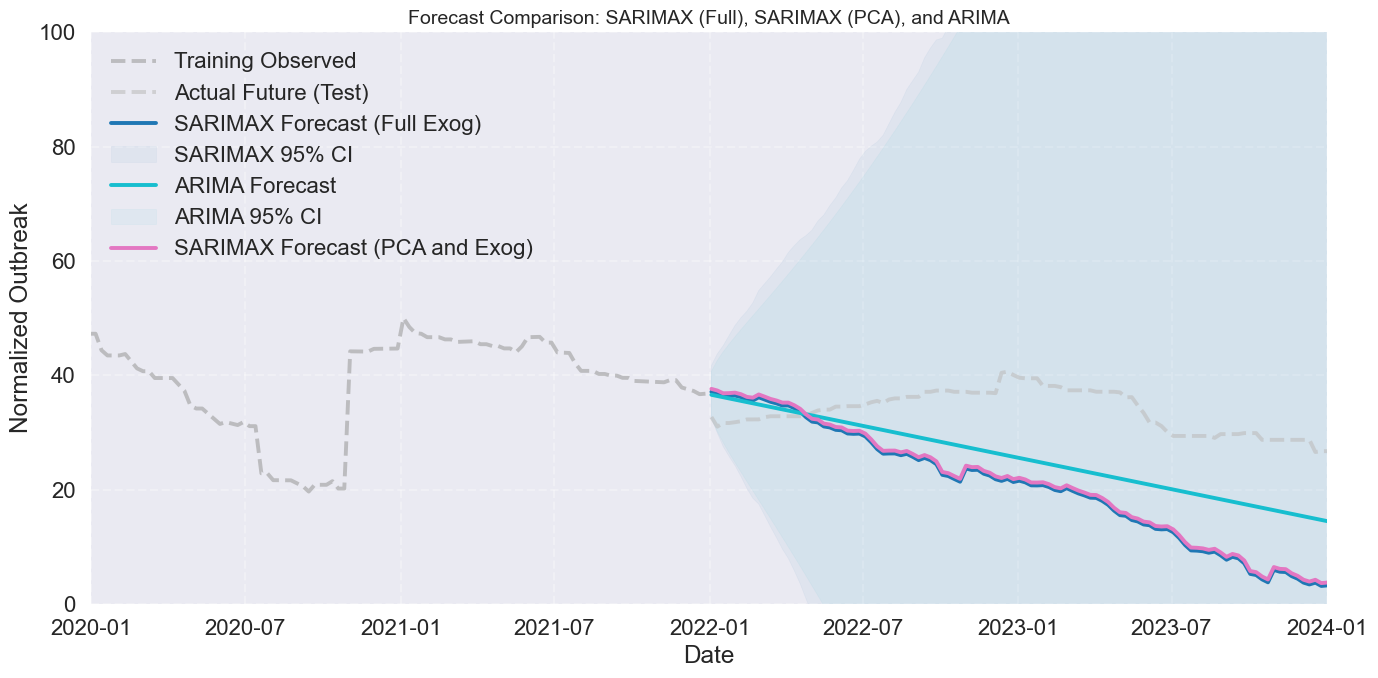

In [327]:
import matplotlib.pyplot as plt

# background
plt.style.use('seaborn-v0_8-dark') 
#plt.style.use('seaborn-v0_8-poster')  
#plt.style.use('seaborn-v0_8-darkgrid')  

offset = 0.5
plt.figure(figsize=(14, 7))

# Historical data
plt.plot(y_train, label='Training Observed', color='#9e9e9e', linestyle='--', alpha=0.6)
plt.plot(y_test, label='Actual Future (Test)', color='#bdbdbd', linestyle='--', alpha=0.6)

# SARIMAX forecast Full Exog
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast (Full Exog)', color='#1f77b4')
plt.fill_between(forecast_mean.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='#1f77b4', alpha=0.05, label='SARIMAX 95% CI')

# ARIMA forecast
plt.plot(forecast_mean_arima.index, forecast_mean_arima, label='ARIMA Forecast', color='#17becf')
plt.fill_between(forecast_mean_arima.index,
                 conf_int_arima.iloc[:, 0],
                 conf_int_arima.iloc[:, 1],
                 color='#17becf', alpha=0.05, label='ARIMA 95% CI')

# PCA-based SARIMAX forecast 
plt.plot(forecast_mean_pca.index, forecast_mean_pca + offset, label='SARIMAX Forecast (PCA and Exog)', color='#e377c2')

# Title and labels
plt.title('Forecast Comparison: SARIMAX (Full), SARIMAX (PCA), and ARIMA', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Normalized Outbreak')
plt.legend()
plt.ylim(bottom=0, top=100)
plt.xlim(left='2020', right='2024')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [328]:
# SARIMAX (Full Exog)
mse = mean_squared_error(y_test[:len(forecast_mean)], forecast_mean)
mae = mean_absolute_error(y_test[:len(forecast_mean)], forecast_mean)
print("SARIMAX (Full Exog)")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}\n")

# SARIMAX (PCA Exog)
mse = mean_squared_error(y_test[:len(forecast_mean_pca)], forecast_mean_pca)
mae = mean_absolute_error(y_test[:len(forecast_mean_pca)], forecast_mean_pca)
print("SARIMAX (PCA Exog)")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}\n")

# SARIMA (No Exog)
mse = mean_squared_error(y_test[:len(forecast_mean_sarima)], forecast_mean_sarima)
mae = mean_absolute_error(y_test[:len(forecast_mean_sarima)], forecast_mean_sarima)
print("SARIMA (No Exog)")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}\n")

# ARIMA (No Exog)
mse = mean_squared_error(y_test[:len(forecast_mean_arima)], forecast_mean_arima)
mae = mean_absolute_error(y_test[:len(forecast_mean_arima)], forecast_mean_arima)
print("ARIMA (No Exog)")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

SARIMAX (Full Exog)
Test MSE: 282.8375
Test MAE: 14.9444

SARIMAX (PCA Exog)
Test MSE: 282.8339
Test MAE: 14.9443

SARIMA (No Exog)
Test MSE: 290.0842
Test MAE: 15.1118

ARIMA (No Exog)
Test MSE: 107.6283
Test MAE: 9.3143


### moving window 

In [206]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

window_size = 104  # 2 years of weekly data
forecast_horizon = 1  # 1-step (week) ahead forecast

predictions = []
true_values = []

# Loop over moving windows
for i in range(window_size, len(y) - forecast_horizon):
    # Split data into train window and one-step test
    y_train = y.iloc[i - window_size:i]
    y_test = y.iloc[i:i + forecast_horizon]

    X_train = X.iloc[i - window_size:i]
    X_test = X.iloc[i:i + forecast_horizon]

    try:
        # Fit SARIMAX
        model = SARIMAX(y_train, exog=X_train,
                        order=(1,2,2), seasonal_order=(0,1,1,52),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        result = model.fit(disp=False)

        # Forecast one step ahead
        forecast = result.get_forecast(steps=forecast_horizon, exog=X_test)
        pred = forecast.predicted_mean.iloc[0]

        # Store result
        predictions.append(pred)
        true_values.append(y_test.iloc[0])

    except:
        # If model fails, skip (or fill NaN)
        predictions.append(np.nan)
        true_values.append(y_test.iloc[0])

In [207]:
from sklearn.metrics import mean_squared_error

# Drop any NaNs due to failed iterations
valid_preds = ~np.isnan(predictions)
mse = mean_squared_error(np.array(true_values)[valid_preds], np.array(predictions)[valid_preds])

print(f"Moving Window MSE (1-step ahead): {mse:.4f}")

Moving Window MSE (1-step ahead): 87.0285


In [208]:
import pandas as pd
import matplotlib.pyplot as plt

# Trim NaNs from earlier if needed
pred_series = pd.Series(predictions, index=y.index[window_size:window_size + len(predictions)])
true_series = pd.Series(true_values, index=y.index[window_size:window_size + len(true_values)])


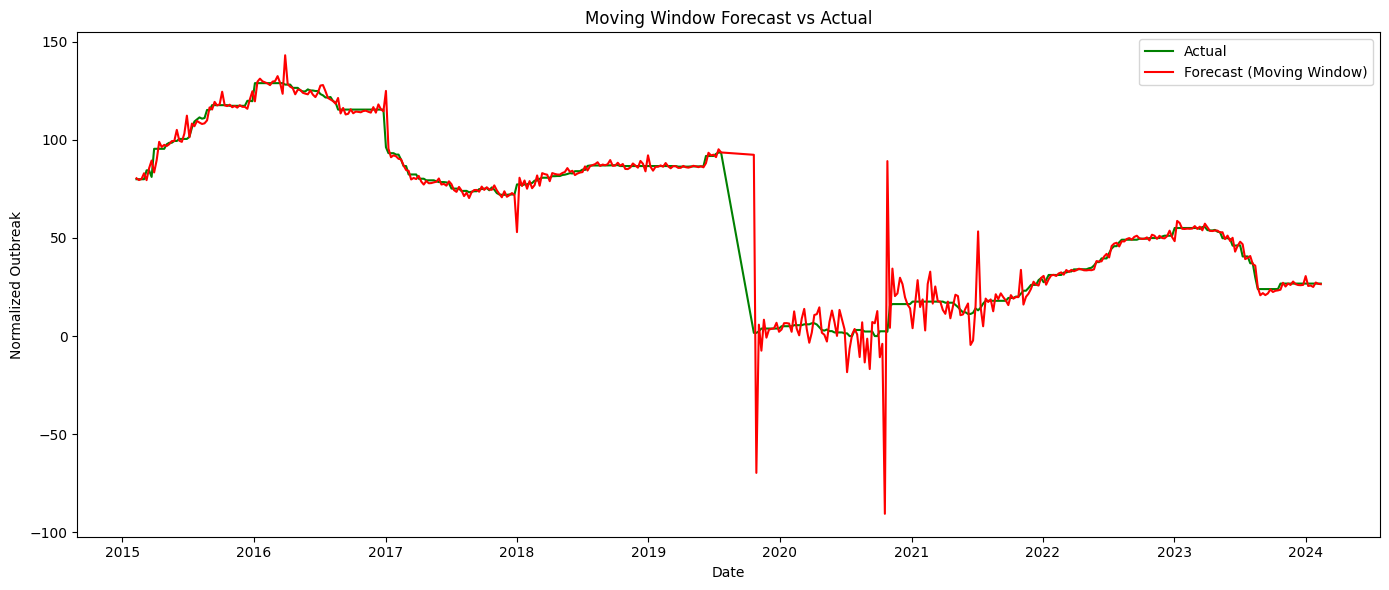

In [209]:
plt.figure(figsize=(14, 6))
plt.plot(true_series, label='Actual', color='green')
plt.plot(pred_series, label='Forecast (Moving Window)', color='red')
plt.title('Moving Window Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Normalized Outbreak')
plt.legend()
plt.tight_layout()
plt.show()

### TCN 

In [611]:
lookback = 150

# 1. Scale exogenous features
X_all = df_week[['Sea temperature', 'Total lice counts']]
x_scaler = MinMaxScaler()
X_scaled = pd.DataFrame(x_scaler.fit_transform(X_all), columns=X_all.columns, index=X_all.index)

def create_tcn_data(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X.iloc[i-lookback:i].values)
        ys.append(y.iloc[i])  # next target value
    return np.array(Xs), np.array(ys)

# Use your scaled exog + target
X_all = df_week[['Sea temperature', 'Total lice counts']]
y_all = df_week['Norm_Outbreak']

X_seq, y_seq = create_tcn_data(X_all, y_all, lookback)

### hyperp tuning

        64            4  [2, 4, 8]          0.010          32   93.660080

In [653]:
from itertools import product
from sklearn.metrics import mean_squared_error

# Define hyperparameter grid
nb_filters_list =  [64,128]
kernel_sizes = [4,5]
dilation_sets = [[2, 4, 8], [1,2,4,8]]
learning_rates = [0.01,0.001]
batch_sizes = [32,64]

# Store results
results = []

# Run grid search
for nb_filters, kernel_size, dilations, lr, batch_size in product(
        nb_filters_list, kernel_sizes, dilation_sets, learning_rates, batch_sizes):

    # Build model
    model = Sequential([
        InputLayer(input_shape=(lookback, X_seq.shape[2])),
        TCN(nb_filters=nb_filters, kernel_size=kernel_size, dilations=dilations, kernel_initializer='orthogonal'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    # Train model with validation split
    history = model.fit(
        X_seq_train, y_seq_train,
        epochs=30,
        batch_size=batch_size,
        validation_split=0.1,
        shuffle=False,
        verbose=0
    )

    # Validation MSE from final epoch
    val_mse = history.history['val_loss'][-1]

    # Evaluate on true test set
    y_pred = model.predict(X_seq_test).flatten()
    test_mse = mean_squared_error(y_seq_test, y_pred)

    # Store results
    results.append({
        'nb_filters': nb_filters,
        'kernel_size': kernel_size,
        'dilations': dilations,
        'learning_rate': lr,
        'batch_size': batch_size,
        'val_mse': val_mse,
        'test_mse': test_mse
    })

    print(f"filters={nb_filters}, kernel={kernel_size}, dilations={dilations}, "
          f"lr={lr}, batch={batch_size}, val_MSE={val_mse:.4f}, test_MSE={test_mse:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
filters=64, kernel=4, dilations=[2, 4, 8], lr=0.01, batch=32, val_MSE=79.2963, test_MSE=336.9966
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
filters=64, kernel=4, dilations=[2, 4, 8], lr=0.01, batch=64, val_MSE=126.9012, test_MSE=446.6103
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
filters=64, kernel=4, dilations=[2, 4, 8], lr=0.001, batch=32, val_MSE=310.1510, test_MSE=474.5251
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
filters=64, kernel=4, dilations=[2, 4, 8], lr=0.001, batch=64, val_MSE=451.1917, test_MSE=569.1861
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
filters=64, kernel=4, dilations=[1, 2, 4, 8], lr=0.01, batch=32, val_MSE=181.6052, test_MSE=430.1891
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
filters=64, kernel=4, dilations=[1, 2, 4, 8], lr=0.01, batch=64, val_MSE=431.2429, test_MSE=886.2379
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
filters=64, kernel=4, dilations=[1, 2, 4, 8], lr=0.001, batch=32, val_MSE=144.4507, test_MSE=465.4504
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

### TCN fit

In [654]:
# Convert to DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Sort by validation MSE
best = results_df.sort_values(by='val_mse').head(5)

print("\n🔍 Top 5 Configurations by Validation MSE:")
print(best)


🔍 Top 5 Configurations by Validation MSE:
    nb_filters  kernel_size     dilations  learning_rate  batch_size  \
9           64            5     [2, 4, 8]          0.010          64   
0           64            4     [2, 4, 8]          0.010          32   
20         128            4  [1, 2, 4, 8]          0.010          32   
16         128            4     [2, 4, 8]          0.010          32   
22         128            4  [1, 2, 4, 8]          0.001          32   

       val_mse    test_mse  
9    47.072594  341.155142  
0    79.296333  336.996595  
20   97.214317  203.788359  
16  103.508484  381.111661  
22  106.480377  377.721902  


In [662]:
from tcn import TCN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer

# 64,5,2,4,8, 32

model = Sequential([
    InputLayer(input_shape=(lookback, X_seq.shape[2])),
    TCN(nb_filters=64, 
        kernel_size=5, dilations=[2, 4, 8],
        use_layer_norm=True,
        kernel_initializer='orthogonal'),
    Dense(1)  # Predict 1 value
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

from sklearn.model_selection import train_test_split

# Split the TCN input/output
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False  # No shuffle to preserve time order
)
history = model.fit(X_seq_train, y_seq_train, epochs=100, batch_size=64, validation_split=0.1)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3407.0256 - val_loss: 167.3301
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1878.8816 - val_loss: 42.4662
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1406.5088 - val_loss: 8.2545
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1231.6885 - val_loss: 77.9253
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 920.1609 - val_loss: 250.8530
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 776.7468 - val_loss: 495.6066
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 694.1205 - val_loss: 724.6380
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 726.9930 - val_loss: 852.4551
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 744.2029 - val_loss: 859.0431
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 745.5952 - val_loss: 772.5886
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 704.6403 - val_loss: 647.6459
Epoch 12/100
5/5 ━━━━━━━━━━━━━

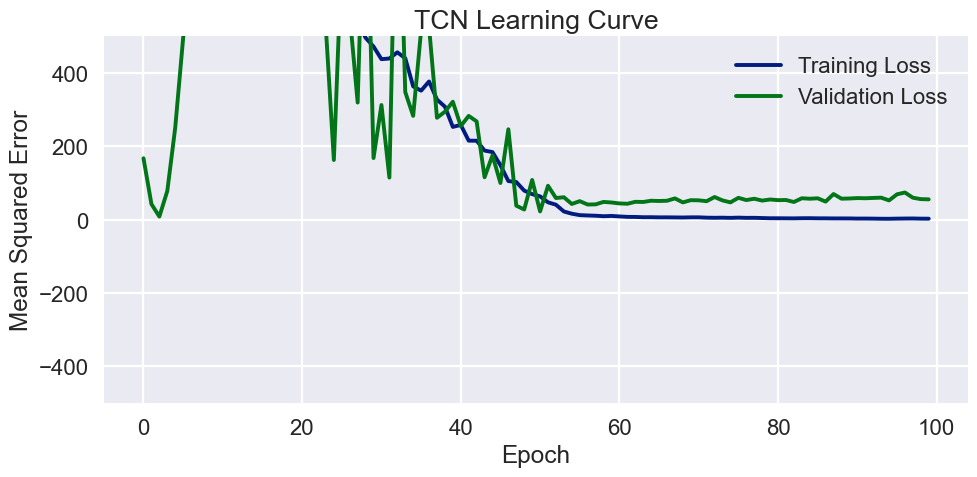

In [663]:
# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('TCN Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.ylim(top=500, bottom = -500)
plt.grid(True)
plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
TCN Forecast MSE: 105.9625


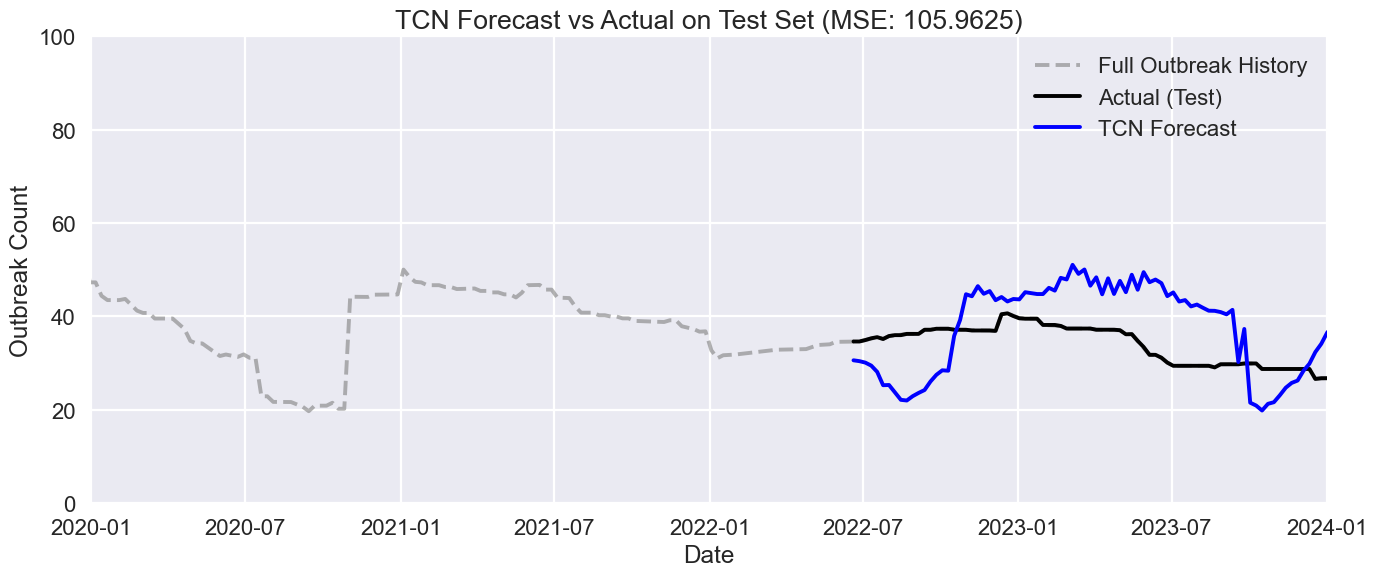

In [664]:
from sklearn.metrics import mean_squared_error

y_pred_tcn = model.predict(X_seq_test).flatten()
mse_tcn = mean_squared_error(y_seq_test, y_pred_tcn)

print(f"TCN Forecast MSE: {mse_tcn:.4f}")


# Create a time index for the test forecast (same length as y_seq_test)
forecast_index = y_all.index[-len(y_seq_test):]

# Plot

plt.figure(figsize=(14, 6))
plt.style.use('seaborn-v0_8-dark') 
# Full historical series
plt.plot(y_all.index, y_all, label='Full Outbreak History', color='gray', linestyle='--', alpha=0.6)

# Actual values for test period
plt.plot(forecast_index, y_seq_test, label='Actual (Test)', color='black')

# TCN forecast
plt.plot(forecast_index, y_pred_tcn, label='TCN Forecast', color='blue')

plt.title(f'TCN Forecast vs Actual on Test Set (MSE: {mse_tcn:.4f})')
plt.xlabel('Date')
plt.ylabel('Outbreak Count')
plt.legend()
plt.ylim(bottom=0, top= 100)
plt.xlim(left='2020', right='2024')
plt.grid(True)
plt.tight_layout()
plt.show()

In [649]:
bias = np.mean(y_pred_tcn - y_seq_test)
print(f"Mean Prediction Bias: {bias:.4f}")

Mean Prediction Bias: 9.5699


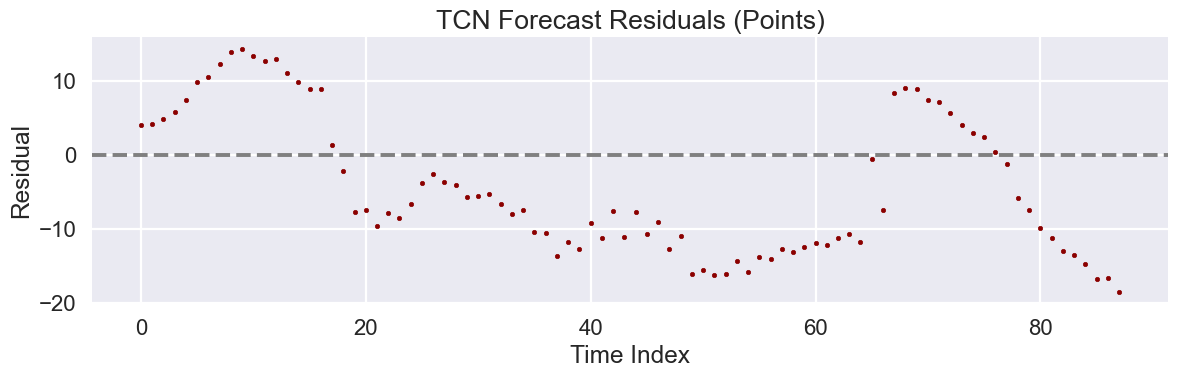

In [665]:
residuals = y_seq_test - y_pred_tcn

plt.figure(figsize=(12, 4))
plt.scatter(range(len(residuals)), residuals, color='darkred', s=10)  # s controls point size
plt.axhline(0, color='gray', linestyle='--')
plt.title('TCN Forecast Residuals (Points)')
plt.xlabel('Time Index')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()